# 13.6 Lab: Multiple Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats
from statsmodels.stats.multitest import multipletests, fdrcorrection
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from itertools import combinations

import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

%load_ext rpy2.ipython

## 13.6.1 Review of Hypothesis Tests

In [2]:
%%R
set.seed(6)
x <- matrix(rnorm(10 * 100), 10, 100)
x[, 1:50] <- x[, 1:50] + 0.5

In [3]:
data = robjects.r("""
set.seed(6)
x <- matrix(rnorm(10 * 100), 10, 100)
x[, 1:50] <- x[, 1:50] + 0.5
x <- x
""")

x_array = np.array(data)
#x_array[:, 0:50] = x_array[:,0:50] + 0.5

In [4]:
%%R
t.test(x[, 1], mu = 0)


	One Sample t-test

data:  x[, 1]
t = 2.0841, df = 9, p-value = 0.06682
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.05171076  1.26242719
sample estimates:
mean of x 
0.6053582 



In [5]:
scipy.stats.ttest_1samp(x_array[:, 0], popmean=0)

TtestResult(statistic=2.084127359877953, pvalue=0.06681661446371615, df=9)

In [6]:
%%R
p.values <- rep(0, 100)
for (i in 1:100)
    p.values[i] <- t.test(x[, i], mu = 0)$p.value
decision <- rep("Do not reject H0", 100)
decision[p.values <= 0.05] <- "Reject H0"
table(decision,
     c(rep("H0 is False", 50), rep("H0 is True", 50))
     )

                  
decision           H0 is False H0 is True
  Do not reject H0          40         47
  Reject H0                 10          3


In [7]:
p_values = np.array([])
decisions = np.array([])

for i in range(x_array.shape[1]):
    p_val = scipy.stats.ttest_1samp(x_array[:, i], popmean=0).pvalue
    p_values = np.append(p_values, p_val)
    if p_val <= 0.05:
        decision = 'Reject H0'
    else:
        decision = 'Do not reject H0'
    decisions = np.append(decisions, decision)
    
decisions_df = pd.DataFrame({"Decisions":decisions})
decisions_df['H0_truth_val'] = 'H0 is False'
decisions_df['H0_truth_val'].iloc[50:,] = 'H0 is True'

pd.crosstab(decisions_df['Decisions'], decisions_df['H0_truth_val'], values = decisions_df['H0_truth_val'], aggfunc='count')

H0_truth_val,H0 is False,H0 is True
Decisions,,
Do not reject H0,40,47
Reject H0,10,3


In [8]:
%%R
x <- matrix(rnorm(10 * 100), 10, 100)
x[, 1:50] <- x[, 1:50] + 1
for (i in 1:100)
    p.values[i] <- t.test(x[, i], mu=0)$p.value
decision <- rep("Do no reject H0", 100)
decision[p.values <= 0.05] <- 'Reject H0'
table(decision,
     c(rep("H0 is False", 50), rep("H0 is True", 50))
     )

                 
decision          H0 is False H0 is True
  Do no reject H0           9         49
  Reject H0                41          1


In [9]:
x_array = np.random.normal(loc=0, scale=1, size=1000).reshape(10, 100)
x_array[:, 0:50] = x_array[:, 0:50] + 1

p_values = np.array([])
decisions = np.array([])

for i in range(x_array.shape[1]):
    p_val = scipy.stats.ttest_1samp(x_array[:, i], popmean=0).pvalue
    p_values = np.append(p_values, p_val)
    if p_val <= 0.05:
        decision = 'Reject H0'
    else:
        decision = 'Do not reject H0'
    decisions = np.append(decisions, decision)
    
decisions_df = pd.DataFrame({"Decisions":decisions})
decisions_df['H0_truth_val'] = 'H0 is False'
decisions_df['H0_truth_val'].iloc[50:,] = 'H0 is True'

pd.crosstab(decisions_df['Decisions'], decisions_df['H0_truth_val'], values = decisions_df['H0_truth_val'], aggfunc='count')

H0_truth_val,H0 is False,H0 is True
Decisions,,
Do not reject H0,11,49
Reject H0,39,1


## 13.6.2 The Family-Wise Error Rate

In [10]:
%%R
m <- 1:500
fwe1 <- 1 - (1 - 0.05)^m
fwe2 <- 1 - (1 - 0.01)^m
fwe3 <- 1 - (1 - 0.001)^m

In [11]:
m = np.arange(1,501)
fwe1 = 1 - (1 - 0.05)**m
fwe2 = 1 - (1 - 0.01)**m
fwe3 = 1 - (1 - 0.001)**m

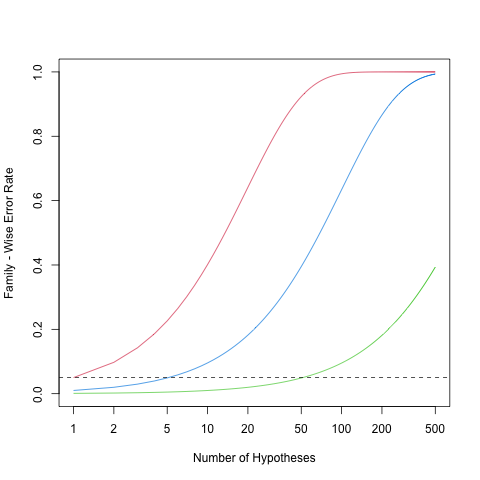

In [12]:
%%R
par(mfrow = c(1, 1))
plot(m, fwe1, type = 'l', log = 'x', ylim = c(0, 1), col = 2,
    ylab = 'Family - Wise Error Rate',
    xlab = 'Number of Hypotheses')
lines(m, fwe2, col = 4)
lines(m, fwe3, col = 3)
abline(h = 0.05, lty = 2)

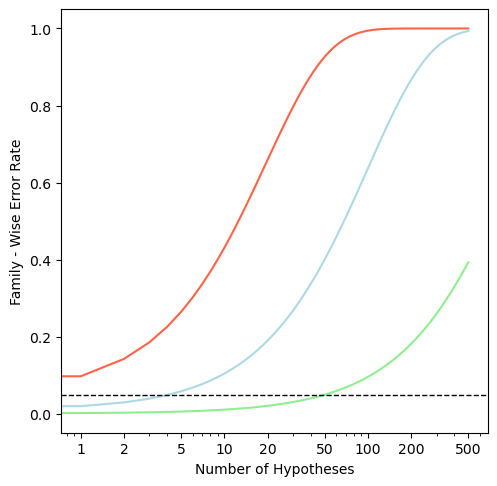

In [13]:
plt.figure(figsize=(5.5,5.5))
plt.plot(fwe1, color='tomato')
plt.plot(fwe2, color='lightblue')
plt.plot(fwe3, color='lightgreen')
plt.xscale('log')
plt.xlabel("Number of Hypotheses")
plt.ylabel("Family - Wise Error Rate")
plt.xticks([1, 2, 5, 10, 20, 50, 100, 200, 500], ['1', '2', '5', '10', '20', '50', '100', '200', '500'])
plt.axhline(0.05, color='black', linestyle='--', lw=1);

In [14]:
%%R
library(ISLR2)
fund.mini <- Fund[, 1:5]
t.test(fund.mini[, 1], mu = 0)


	One Sample t-test

data:  fund.mini[, 1]
t = 2.8604, df = 49, p-value = 0.006202
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.8923397 5.1076603
sample estimates:
mean of x 
        3 



In [15]:
%%R
fund.pvalue <- rep(0, 5)
for (i in 1:5)
    fund.pvalue[i] <- t.test(fund.mini[, i], mu = 0)$p.value
fund.pvalue

[1] 0.006202355 0.918271152 0.011600983 0.600539601 0.755781508


In [16]:
data = robjects.r("""
library(ISLR2)
fund <- Fund
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    fund_df = robjects.conversion.rpy2py(data)

In [17]:
fund_mini = fund_df.iloc[:, 0:5]
scipy.stats.ttest_1samp(fund_mini.iloc[:, 0], popmean = 0)

TtestResult(statistic=2.8603877677367766, pvalue=0.00620235548553822, df=49)

In [18]:
fund_p_values = np.array([])

for i in range(5):
    p_val = scipy.stats.ttest_1samp(fund_mini.iloc[:, i], popmean = 0).pvalue
    fund_p_values = np.append(fund_p_values, p_val)
fund_p_values

array([0.00620236, 0.91827115, 0.01160098, 0.6005396 , 0.75578151])

In [19]:
%%R
p.adjust(fund.pvalue, method = 'bonferroni')

[1] 0.03101178 1.00000000 0.05800491 1.00000000 1.00000000


In [20]:
multipletests(fund_p_values, method='bonferroni')[1]

array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ])

In [21]:
a = fund_p_values * 5
a[a > 1] = 1
a

array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ])

In [22]:
%%R
p.adjust(fund.pvalue, method = 'holm')

[1] 0.03101178 1.00000000 0.04640393 1.00000000 1.00000000


In [23]:
multipletests(fund_p_values, method='holm')[1]

array([0.03101178, 1.        , 0.04640393, 1.        , 1.        ])

In [24]:
%%R
apply(fund.mini, 2, mean)

Manager1 Manager2 Manager3 Manager4 Manager5 
     3.0     -0.1      2.8      0.5      0.3 


In [25]:
fund_mini.mean(axis=0)

Manager1    3.0
Manager2   -0.1
Manager3    2.8
Manager4    0.5
Manager5    0.3
dtype: float64

In [26]:
%%R
t.test(fund.mini[, 1], fund.mini[, 2], paired=T)


	Paired t-test

data:  fund.mini[, 1] and fund.mini[, 2]
t = 2.128, df = 49, p-value = 0.03839
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 0.1725378 6.0274622
sample estimates:
mean difference 
            3.1 



In [27]:
scipy.stats.ttest_rel(fund_mini.iloc[:, 0], fund_mini.iloc[:, 1])

TtestResult(statistic=2.128014948148984, pvalue=0.038391072368079454, df=49)

In [28]:
%%R
returns <- as.vector(as.matrix(fund.mini))
manager <- rep(c('1', '2', '3', '4', '5'), rep(50, 5))
a1 <- aov(returns ~ manager)
TukeyHSD(x = a1)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = returns ~ manager)

$manager
    diff        lwr       upr     p adj
2-1 -3.1 -6.9865435 0.7865435 0.1861585
3-1 -0.2 -4.0865435 3.6865435 0.9999095
4-1 -2.5 -6.3865435 1.3865435 0.3948292
5-1 -2.7 -6.5865435 1.1865435 0.3151702
3-2  2.9 -0.9865435 6.7865435 0.2452611
4-2  0.6 -3.2865435 4.4865435 0.9932010
5-2  0.4 -3.4865435 4.2865435 0.9985924
4-3 -2.3 -6.1865435 1.5865435 0.4819994
5-3 -2.5 -6.3865435 1.3865435 0.3948292
5-4 -0.2 -4.0865435 3.6865435 0.9999095



In [29]:
tukey_df = pd.DataFrame(
    {
        "score": pd.concat(
            [
                fund_mini["Manager1"],
                fund_mini["Manager2"],
                fund_mini["Manager3"],
                fund_mini["Manager4"],
                fund_mini["Manager5"],
            ]
        ),
        "group": np.repeat(
            ["Manager1", "Manager2", "Manager3", "Manager4", "Manager5"], repeats=50
        ),
    }
)

tukey = pairwise_tukeyhsd(tukey_df['score'], tukey_df['group'], alpha=0.05)

print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
Manager1 Manager2     -3.1 0.1862 -6.9865 0.7865  False
Manager1 Manager3     -0.2 0.9999 -4.0865 3.6865  False
Manager1 Manager4     -2.5 0.3948 -6.3865 1.3865  False
Manager1 Manager5     -2.7 0.3152 -6.5865 1.1865  False
Manager2 Manager3      2.9 0.2453 -0.9865 6.7865  False
Manager2 Manager4      0.6 0.9932 -3.2865 4.4865  False
Manager2 Manager5      0.4 0.9986 -3.4865 4.2865  False
Manager3 Manager4     -2.3  0.482 -6.1865 1.5865  False
Manager3 Manager5     -2.5 0.3948 -6.3865 1.3865  False
Manager4 Manager5     -0.2 0.9999 -4.0865 3.6865  False
-------------------------------------------------------


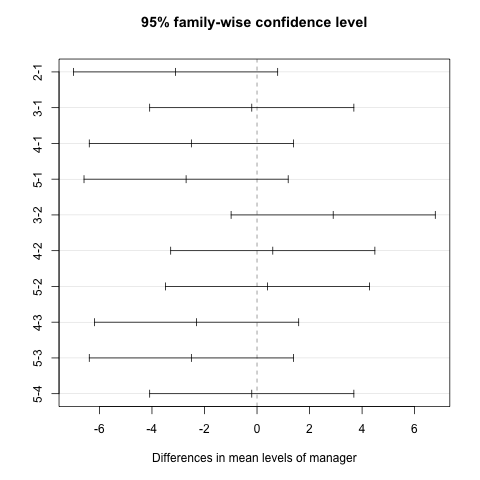

In [30]:
%%R
plot(TukeyHSD(x = a1))

In [31]:
combs = combinations(tukey.groupsunique, r=2)
combs = list(combs)

labels = []
for comb in combs:
    label = comb[1] + '-' + comb[0]
    labels.append(label)
    
labels.reverse()

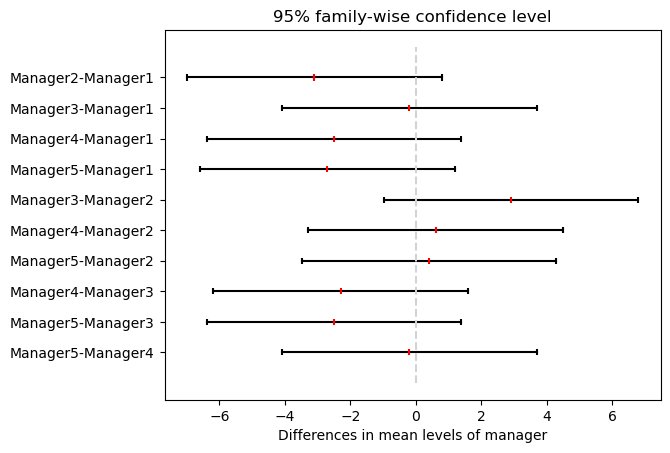

In [32]:
conf_ints = tukey.confint
conf_ints = np.flip(conf_ints, axis=0)

mean_diffs = tukey.meandiffs
mean_diffs = np.flip(mean_diffs, axis=0)

for i, conf_int in enumerate(conf_ints):
    plt.plot(conf_int, (i,i), color='black')
    plt.vlines(conf_int[0], ymin=i-0.1, ymax=i+0.1, color='black')
    plt.vlines(conf_int[1], ymin=i-0.1, ymax=i+0.1, color='black')
for i, diff in enumerate(mean_diffs):
    plt.vlines(diff, ymin=i-0.1, ymax=i+0.1, color='red')
    
plt.vlines(0, ymin=-1, ymax=10, linestyle='--', color='lightgrey')

plt.yticks(ticks = np.arange(0,10,1), labels=labels)
plt.title('95% family-wise confidence level')
plt.xlabel("Differences in mean levels of manager");

In [33]:
# fig, ax = plt.subplots(1,1)
# tukey.plot_simultaneous(ax=ax)

In [34]:
# res = scipy.stats.tukey_hsd(fund_mini['Manager1'], fund_mini['Manager2'], fund_mini['Manager3'], fund_mini['Manager4'], fund_mini['Manager5'])
# print(res)

## 13.6.3 The False Discovery Rate

In [35]:
%%R
fund.pvalues <- rep(0, 2000)
for (i in 1:2000)
    fund.pvalues[i] <- t.test(Fund[, i], mu = 0)$p.value

In [36]:
num_managers = fund_df.shape[1]
fund_p_values = np.array([])

for i in range(num_managers):
    p_val = scipy.stats.ttest_1samp(fund_df.iloc[:, i], popmean = 0).pvalue
    fund_p_values = np.append(fund_p_values, p_val)

In [37]:
%%R
q.values.BH <- p.adjust(fund.pvalues, method='BH')
q.values.BH[1:10]

 [1] 0.08988921 0.99149100 0.12211561 0.92342997 0.95603587 0.07513802
 [7] 0.07670150 0.07513802 0.07513802 0.07513802


In [38]:
BH = fdrcorrection(fund_p_values)

q_values_BH = BH[1]

q_values_BH[0:10]

array([0.08988921, 0.991491  , 0.12211561, 0.92342997, 0.95603587,
       0.07513802, 0.0767015 , 0.07513802, 0.07513802, 0.07513802])

In [39]:
%%R
sum(q.values.BH <= 0.1)

[1] 146


In [40]:
sum(q_values_BH <= 0.1)

146

In [41]:
%%R
sum(fund.pvalues <= (0.1 / 2000))

[1] 0


In [42]:
sum(fund_p_values <= (0.1 / 2000))

0

In [43]:
%%R
ps <- sort(fund.pvalues)
m <- length(fund.pvalues)
q <- 0.1
wh.ps <- which(ps < q * (1:m) / m)
if (length(wh.ps) > 0) {
    wh <- 1:max(wh.ps)
} else {
    wh <- numeric(0)
}

In [44]:
ps = np.sort(fund_p_values)
m = len(fund_p_values)
q = 0.1
wh_ps = np.where(ps < q * np.arange(1, m + 1) / m)[0]

if len(wh_ps) > 0:
    wh = np.arange(max(wh_ps) + 1)
else:
    wh = 0

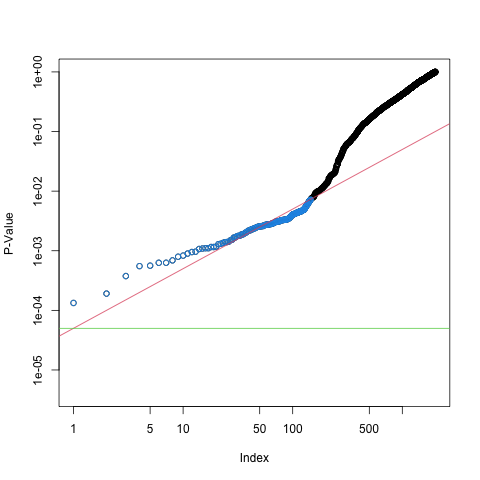

In [45]:
%%R
plot(ps, log = 'xy', ylim = c(4e-6, 1), ylab = 'P-Value',
     xlab = 'Index', main = '')
points(wh, ps[wh], col = 4)
abline(a = 0, b = (q / m), col = 2, untf = TRUE)
abline(h = 0.1 / 2000, col = 3)

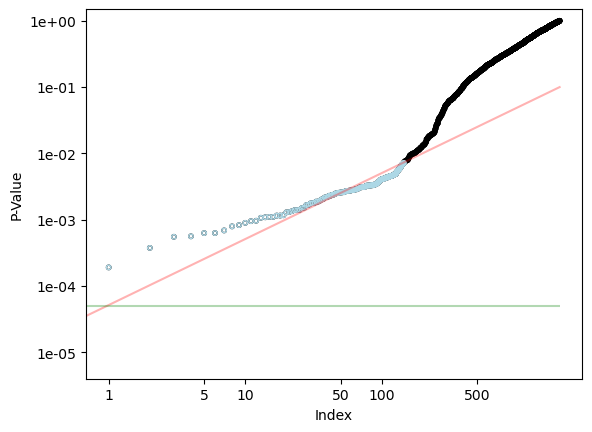

In [46]:
xs = np.arange(0, len(ps) )
marker_size = 10
alpha = 0.3

plt.scatter(xs, ps, facecolor='none', edgecolor='black', s=marker_size)
plt.scatter(wh, ps[wh], facecolor='none', edgecolor='lightblue', s=marker_size)
plt.plot([0, 2000], [0, q], color='red', alpha=alpha)
plt.hlines(0.1 / 2000, xmin=min(xs), xmax=max(xs), color='green', alpha=alpha)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Index')
plt.ylabel('P-Value')

plt.xticks([1, 5, 10, 50, 100, 500], labels=[1, 5, 10, 50, 100, 500])
plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], labels=['1e-05', '1e-04', '1e-03', '1e-02', '1e-01', '1e+00'])

plt.ylim(4e-6, 1.5)

plt.tick_params(which='minor', size=0)
#plt.tick_params(which='minor', width=0)

plt.show()

## 13.6.4 A Re-Sampling Approach

In [47]:
%%R
attach(Khan)
x <- rbind(xtrain, xtest)
y <- c(as.numeric(ytrain), as.numeric(ytest))
dim(x)

[1]   83 2308


In [48]:
data = robjects.r("""
library(ISLR2)
x <- rbind(xtrain, xtest)
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    x = robjects.conversion.rpy2py(data)

x_df = pd.DataFrame(x)
x_df.shape

(83, 2308)

In [49]:
%%R
table(y)

y
 1  2  3  4 
11 29 18 25 


In [50]:
data = robjects.r("""
library(ISLR2)
y <- c(as.numeric(ytrain), as.numeric(ytest))
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    y = robjects.conversion.rpy2py(data)

y_df = pd.DataFrame(y)
y_df.value_counts().sort_index()

1.0    11
2.0    29
3.0    18
4.0    25
dtype: int64

In [51]:
# khan_df = pd.DataFrame(np.column_stack((x,y)))
# khan_df.iloc[:, -1].value_counts().sort_index()

In [52]:
%%R
x <- as.matrix(x)
x1 <- x[which(y == 2), ]
x2 <- x[which(y == 4), ]
n1 <- nrow(x1)
n2 <- nrow(x2)
t.out <- t.test(x1[, 11], x2[, 11], var.equal = TRUE)
TT <- t.out$statistic
TT

        t 
-2.093633 


In [53]:
x1 = x[np.where(y == 2)]
x2 = x[np.where(y == 4)]
n1 = x1.shape[0]
n2 = x2.shape[0]
t_out = scipy.stats.ttest_ind(x1[:, 10], x2[:, 10], equal_var = True)
TT = t_out[0]
TT

-2.0936330736768185

In [54]:
%%R
t.out$p.value

[1] 0.04118644


In [55]:
t_out[1]

0.04118643782678394

In [56]:
%%R
set.seed(1)
B <- 10000
Tbs <- rep(NA, B)
for (b in 1:B) {
    dat <- sample(c(x1[, 11], x2[, 11]))
    Tbs[b] <- t.test(dat[1:n1], dat[n1+1:(n1+n2)], 
                    var.equal=TRUE
                    )$statistic
}
mean((abs(Tbs) >= abs(TT)))

[1] 0.0416


In [57]:
# Because Python uses unsigned ints for its random number generators and R uses signed ints, it's difficult to get them to behave the same.  Therefore the results here will be slightly different in Python than in R 
np.random.seed(2)

Tbs = np.array([])
B = 10000
for b in range(B):
    dat = np.concatenate((x1[:, 10], x2[:, 10]))
    np.random.shuffle(dat)
    result = scipy.stats.ttest_ind(dat[0:n1], dat[n1:(n1+n2)], equal_var=True)
    t_stat = result[0]
    Tbs = np.append(Tbs, t_stat)
np.mean(abs(Tbs) >= abs(TT))

0.0412

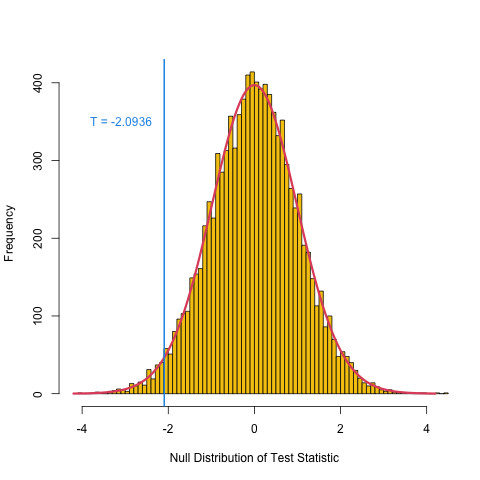

In [58]:
%%R
hist(Tbs, breaks = 100, xlim = c(-4.2, 4.2), main = "",
     xlab = 'Null Distribution of Test Statistic', col = 7)
lines(seq(-4.2, 4.2, len = 1000),
     dt(seq(-4.2, 4.2, len = 1000),
     df = (n1 + n2 - 2)
       ) * 1000, col = 2, lwd = 3)
abline(v = TT, col = 4, lwd = 2)
text(TT - 1, 350, paste("T = ", round(TT, 4), sep = ""), col = 4)

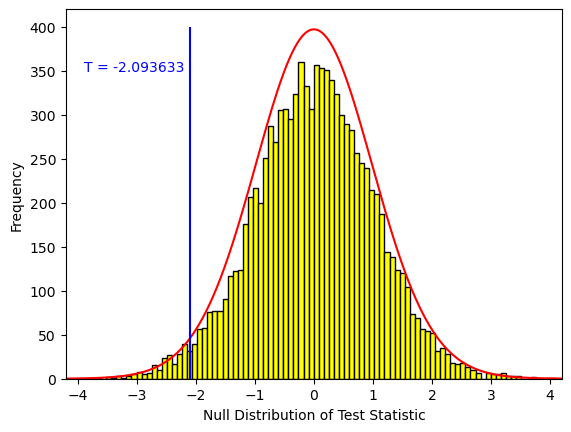

In [59]:
xs = np.linspace(-4.2, 4.2, num = 1000)
ys = scipy.stats.t.pdf(xs, df = (n1 + n2 - 2))

plt.hist(Tbs, bins = 100, color='yellow', edgecolor='black')
plt.plot(xs, ys * 1000, color='red')
plt.vlines(TT, ymin = 0, ymax = 400, color='blue')

plt.annotate(f'T = {TT:4f}', xy = (TT - 0.1, 350), ha='right', color='blue')

plt.xlim(-4.2, 4.2)
plt.xlabel('Null Distribution of Test Statistic')
plt.ylabel('Frequency');

In [60]:
%%R
m <- 100
set.seed(1)
index <- sample(ncol(x1), m)
Ts <- rep(NA, m)
Ts.star <- matrix(NA, ncol = m, nrow = B)
for (j in 1:m) {
    k <- index[j]
    Ts[j] <- t.test(x1[, k], x2[, k],
                    var.equal = TRUE
                   )$statistic
    for (b in 1:B) {
        dat <- sample(c(x1[, k], x2[, k]))
        Ts.star[b, j] <- t.test(dat[1:n1],
            dat[(n1+1):(n1 + n2)], var.equal = TRUE
                               )$statistic
    }
}

In [61]:
data = robjects.r("""
m <- 100
set.seed(1)
index <- sample(ncol(x1), m)
""")

index = np.array(data)
## need to subtract 1 because R starts indexing at 1, but Python starts indexing at 0
index = index - 1

In [62]:
# Because Python uses unsigned ints for its random number generators and R uses signed ints, it's difficult to get them to behave the same.  Therefore the results here will be slightly different in Python than in R

np.random.seed(2)

m = 100

Ts = np.array([])

# Ts_star = pd.DataFrame(index = np.arange(B), columns = np.arange(m))
Ts_star = np.ones((B, m))

for j in range(m):
    k = index[j]
    result = scipy.stats.ttest_ind(x1[:, k], x2[:, k], equal_var=True)
    t_stat = result[0]
    Ts = np.append(Ts, t_stat)
    for b in range(B):
        dat = np.concatenate((x1[:, k], x2[:, k]))
        np.random.shuffle(dat)
        result = scipy.stats.ttest_ind(dat[0:n1], dat[n1:(n1+n2)], equal_var=True)
        t_stat = result[0]
        # Ts_star.iloc[b, j] = t_stat
        Ts_star[b, j] = t_stat

In [63]:
%%R
cs <- sort(abs(Ts))
FDRs <- Rs <- Vs <- rep(NA, m)
for (j in 1:m) {
    R <- sum(abs(Ts) >= cs[j])
    V <- sum(abs(Ts.star) >= cs[j]) / B
    Rs[j] <- R
    Vs[j] <- V
    FDRs[j] <- V / R
}

In [64]:
Rs = np.array([])
Vs = np.array([])
FDRs = np.array([])

cs = np.sort(abs(Ts))
for j in range(m):
    R = np.sum(abs(Ts) >= cs[j])
    V = np.sum(abs(Ts_star) >= cs[j]) / B
    Rs = np.append(Rs, R)
    Vs = np.append(Vs, V)
    FDRs = np.append(FDRs, V / R)

In [65]:
%%R
max(Rs[FDRs <= 0.1])

[1] 15


In [66]:
max(Rs[FDRs <= 0.1])

15.0

In [67]:
%%R
sort(index[abs(Ts) >= min(cs[FDRs < 0.1])])

 [1]   29  465  501  554  573  729  733 1301 1317 1640 1646 1706 1799 1942 2159


In [68]:
np.sort(index[abs(Ts) >= min(cs[FDRs < 0.1])])

array([  28,  464,  500,  553,  572,  728,  732, 1300, 1316, 1639, 1645,
       1705, 1798, 1941, 2158], dtype=int32)

In [69]:
%%R
max(Rs[FDRs <= 0.2])

[1] 28


In [70]:
max(Rs[FDRs <= 0.2])

28.0

In [71]:
%%R
sort(index[abs(Ts) >= min(cs[FDRs < 0.2])])

 [1]   29   40  287  361  369  465  501  554  573  679  729  733  990 1069 1073
[16] 1301 1317 1414 1639 1640 1646 1706 1799 1826 1942 1974 2087 2159


In [72]:
np.sort(index[abs(Ts) >= min(cs[FDRs < 0.2])])

array([  28,   39,  286,  360,  368,  464,  500,  553,  572,  678,  728,
        732,  989, 1068, 1072, 1300, 1316, 1413, 1638, 1639, 1645, 1705,
       1798, 1825, 1941, 1973, 2086, 2158], dtype=int32)

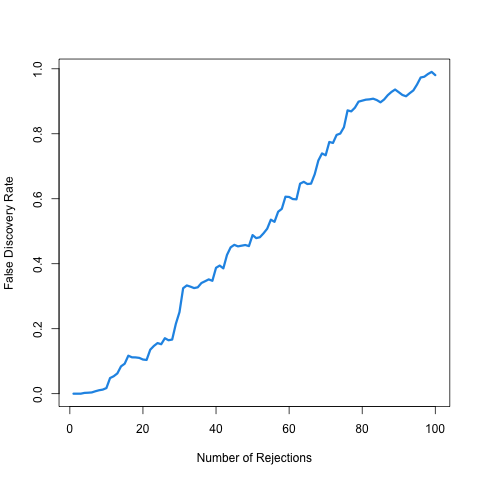

In [73]:
%%R
plot(Rs, FDRs, xlab = "Number of Rejections", type = "l",
     ylab = "False Discovery Rate", col = 4, lwd = 3)

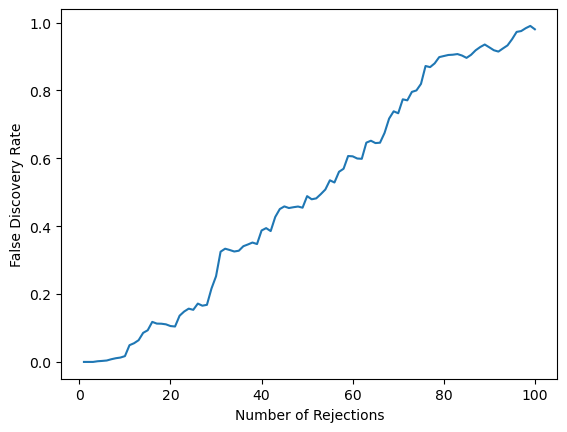

In [74]:
plt.plot(Rs, FDRs)
plt.xlabel("Number of Rejections")
plt.ylabel("False Discovery Rate");